<a href="https://colab.research.google.com/github/QasimWani/simple-transformer/blob/main/mlp/backprop_multi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# The objective behind this file is to implement several ML models from scratch
# First approach is using sklearn - DONE
# Second approach is using Pytorch (2-layer MLP) - DONE
# Third approach is using numpy by deriving MLP and autograds - DONE

In [2]:
import numpy as np
import torch
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import sklearn.datasets

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE

from collections import Counter, defaultdict

In [3]:
ds = sklearn.datasets.load_wine()

In [4]:
X, y = ds['data'], ds['target']

In [5]:
def visualize_distribution(X: np.ndarray, y: np.ndarray):
  mu = X.mean(axis=0)
  var = X.var(axis=0)

  num_features = len(mu)
  num_classes = len(np.unique(y))

  plt.title("Feature distribution")
  plt.bar(np.arange(num_features), mu, yerr=var ** 0.5)
  plt.show()

  plt.title("Label distribution")
  plt.bar(np.arange(num_classes), Counter(y).values())
  plt.show()

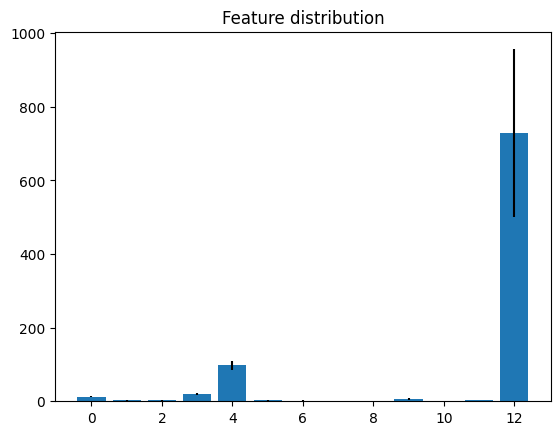

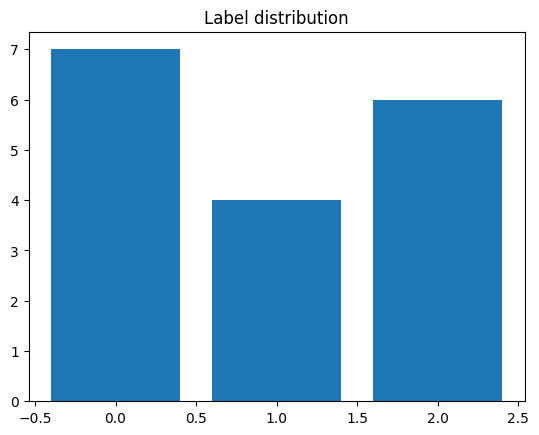

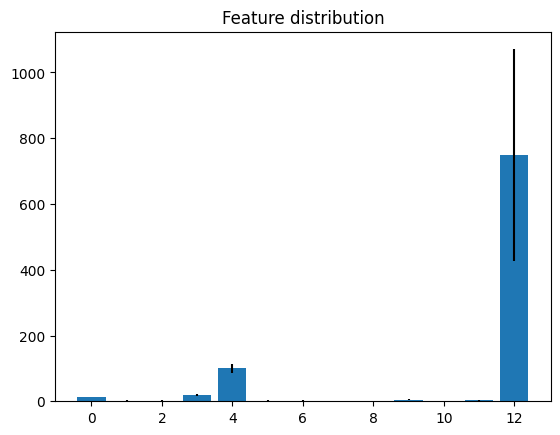

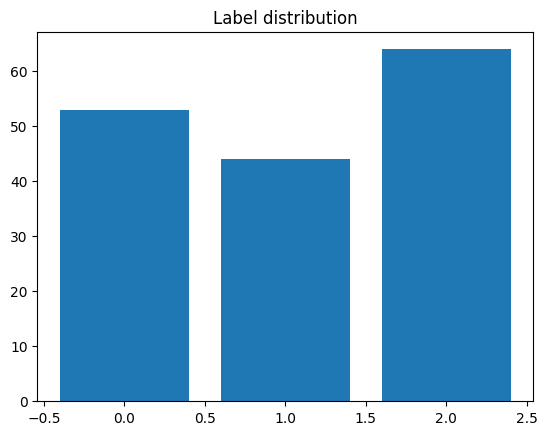

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=0)


visualize_distribution(X_train, y_train)
visualize_distribution(X_test, y_test)


In [7]:
# Okay, so looking at the chart we will need to do two things:

# 1. normalize x-features
# 2. upweight samples from minority class, i.e. class 0 (malignant)

In [8]:
# Step 1. Train baseline model
baseline_model = sklearn.linear_model.LogisticRegression(random_state=0, C=1).fit(X_train, y_train)
baseline_accuracy = sklearn.metrics.f1_score(baseline_model.predict(X_test), y_test, average='macro')
print(baseline_accuracy)

0.868010234075497


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
# okay, great. so baseline performance is very high. 90%. Now, can we get closer to 100%?

def feature_scaling(data: np.ndarray) -> np.ndarray:
  # implement standarization with 0 mean and 1 unit variance
  mu = data.mean(axis=0)
  var = data.var(axis=0)
  out = (data - mu) / var ** 0.5
  assert np.isclose(out.mean(), 0) and np.isclose(out.var(), 1)
  return out


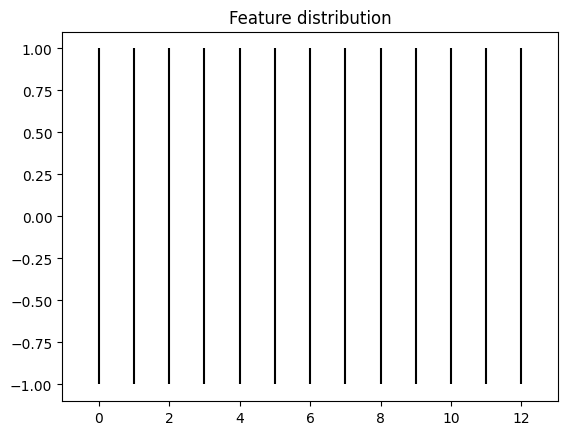

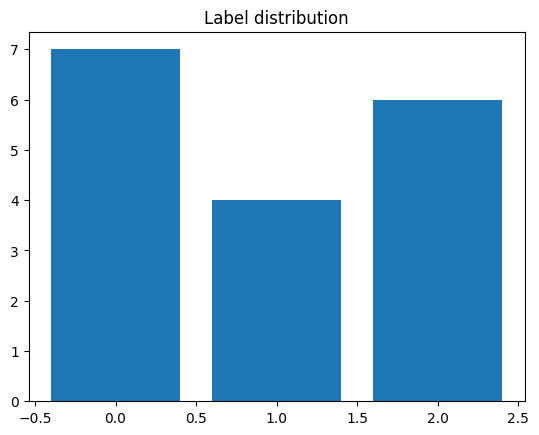

In [10]:
X_train_std = feature_scaling(X_train)
visualize_distribution(X_train_std, y_train)

In [11]:
# Step 2. Train model with scaled input features
baseline_model = sklearn.linear_model.LogisticRegression(random_state=0).fit(X_train_std, y_train)
feature_scaled_accuracy = sklearn.metrics.f1_score(baseline_model.predict(feature_scaling(X_test)), y_test, average='macro')
print(feature_scaled_accuracy)

0.9577873647020176


In [12]:
# Step 3. Interesting. Normalizing input features made no difference. Perhaps we just force class upweighting?
baseline_model = sklearn.linear_model.LogisticRegression(random_state=0, class_weight={0: 0.1, 1: 0.3, 2: 0.6}).fit(X_train_std, y_train)
class_upweighted_accuracy = sklearn.metrics.f1_score(baseline_model.predict(feature_scaling(X_test)), y_test, average='macro')
print(class_upweighted_accuracy)

0.9408819538670284


In [13]:
# Okay, so we improved performnace by 1 percent point. Now, Step 2 -> can we use a simple MLP to boost performance further?

class Network(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features, in_features * 4),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(in_features * 4, out_features * 4),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(out_features * 4, out_features),
        nn.Softmax()
    )

  def forward(self, x):
    return self.layers(x)

In [14]:
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(feature_scaling(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [15]:
def train_network(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs: int):
  in_features, out_features = X_train_tensor.shape[-1], len(torch.unique(y_train_tensor))
  print(f"{in_features} x {out_features}")
  model = Network(in_features, out_features).to(torch.float32)
  optimizer = optim.Adam(model.parameters(), lr=1e-1)
  criterion = nn.CrossEntropyLoss()
  losses = []
  # take gradients every k epochs
  grad_step = 10
  acc_loss = 0.0
  accuracies = []
  for i in range(num_epochs):
    model.train()
    y_hat = model(X_train_tensor)
    loss = criterion(y_hat, y_train_tensor.long())
    acc_loss = acc_loss + loss
    print(f"{loss}", end='\r')

    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    if i % grad_step == 0 and i > 0:
      acc_loss.backward()
      optimizer.step()
      acc_loss = 0.0
      optimizer.zero_grad()

    losses.append(loss.item())
    accuracies.append(validate_model(X_test_tensor, y_test_tensor, model, out_features).item())
  return model, losses, accuracies

@torch.no_grad()
def validate_model(X, y, model, num_classes):
  model.eval()

  y_hat = model(X).numpy()
  return f1_score(y_hat.astype(np.int32), y.numpy().squeeze().astype(np.int32), num_classes)

def accuracy(logits, gt):
  return np.sum(logits.argmax(axis=1) == gt) / len(logits)

def f1_score(logits, gt, num_classes):
  '''
  Calculates macro-f1, i.e. averaging across all classes once we've calculated
  for precision and recall. This is preferred because:
    1) handles class imbalance. precision and recall per class will be all over the place
    if minority class. Taking the average will tank the overall metrics which is desirable.
    2) care specifically about minority classes. Low score will mean heavy class imbalance
    which is useful for calibration and seeing if the model is capable of performing at
    detecting for rare classes
  '''
  tp, fp, tn, fn = confusion_matrix(logits, gt, num_classes)

  # Precision: TP / (TP + FP)
  p = tp / (tp + fp + 1e-7) # shape: num_classes

  # Recall: TP / (TP + FN)
  r = tp / (tp + fn + 1e-7)

  score = 2 * (p * r) / (p + r + 1e-7)
  return score.mean()


def confusion_matrix(logits, gt, num_classes):
  matrix = np.zeros((num_classes, num_classes))
  preds = logits.argmax(axis=1)

  batch_size = len(gt)
  for i in range(batch_size):
    matrix[gt[i], preds[i]] += 1 # the diagonal represent the tp and other elements will be used to calculate fp, fn, and tn


  tp = matrix[np.arange(num_classes), np.arange(num_classes)] # equivalent to np.diag(x). shape: num_classes.

  # False positive. Row indicates gt, col indicates pred. Taking the sum wrt pred is false positive
  fp = np.sum(matrix, axis=0) - tp # num_classes

  # False negative. taking sum along gt means false negative for the same pred you're looking at all the other gt positions, i.e. negatives
  fn = np.sum(matrix, axis=1) - tp # num_classes

  # True negative. just all the samples minus tp + fp + fn
  tn = np.sum(matrix) - (tp + fp + fn)
  return tp, fp, tn, fn # each vector of size num_class


13 x 3


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


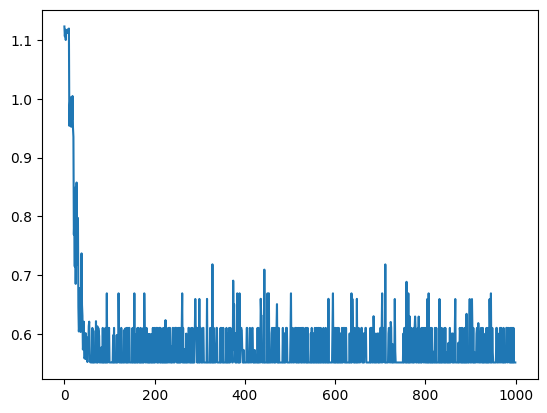

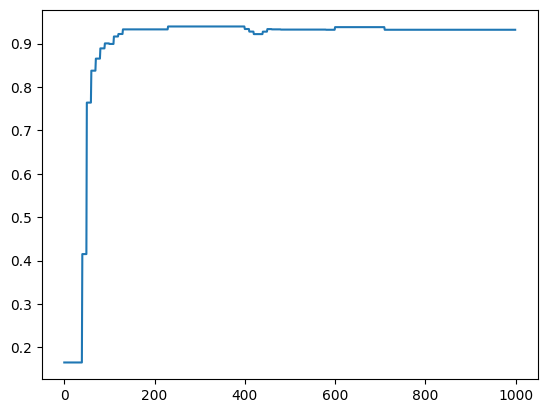

Max F1:0.9395502128999748	Final F1: 0.9319783015405377


In [16]:
model, losses, accuracies = train_network(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 1000)
plt.plot(losses)
plt.show()
plt.plot(accuracies)
plt.show()

print(f"Max F1:{max(accuracies)}\tFinal F1: {accuracies[-1]}")

In [17]:
# Okay, now let's derive this in Numpy. This will be the last step for our puzzle.

In [18]:
def sigmoid(x: np.ndarray) -> np.ndarray:
  x = np.clip(x, -500, 500)
  return 1 / (1 + np.exp(-x))

def d_sigmoid(x: np.ndarray) -> np.ndarray:
  return sigmoid(x) * (1 - sigmoid(x))

def softmax(x: np.ndarray):
  safe_exp = np.exp(x - x.max(axis=-1, keepdims=True))
  _s = np.sum(safe_exp, axis=-1, keepdims=True)
  if np.allclose(_s.sum(), 0):
    return safe_exp / safe_exp.shape[0] # normalize by batch size
  return safe_exp / _s

def d_softmax(x: np.ndarray, grad_output: np.ndarray) -> np.ndarray:
  s = softmax(x)
  sum_term = np.sum(s * grad_output, axis=1, keepdims=True)
  grad_input = s * (grad_output - sum_term)
  return grad_input

def linear(in_features, out_features, scaling_factor:float = 5e-2):
  # W = np.random.rand(in_features, out_features) * scaling_factor
  W = nn.init.xavier_uniform_(torch.empty(in_features, out_features)).numpy()
  b = np.zeros(out_features) # because x @ w + b
  return W, b.reshape(1, -1)

def relu(x):
  return np.where(x < 0, 0, x)

def d_relu(x):
  return (x > 0).astype(x.dtype)

def mse_loss(y, y_hat):
  return np.mean((y_hat - y) ** 2)

def cross_entropy_loss(y, y_hat):
  # L = 1/n ∑ ∑ y * log(y_hat)
  return np.sum(y * np.log(y_hat)) / len(y)

def d_loss_crossentropy(y, y_hat):
  # dL/d_yhat = - ∑ y_i / y_hat
  y_one_hot = np.zeros_like(y_hat)
  y_one_hot[np.arange(len(y)), y.squeeze()] = 1
  return -y_one_hot / (y_hat + 1e-7)

def d_loss_mse(y, y_hat):
  return 2 * (y_hat - y)

In [19]:
class Network:
  def __init__(self, in_features, out_features, eta):
      self.eta = eta # learning rate
      self.in_features = in_features
      self.hidden_size = in_features * 32
      self.out_features = out_features

      ln1 = linear(self.in_features, self.hidden_size)
      self.W1 = ln1[0] # (in_features, hidden_size)
      self.b1 = ln1[1] # (hidden_size)

      ln2 = linear(self.hidden_size, self.out_features)
      self.W2 = ln2[0] # (hidden_size, out_features)
      self.b2 = ln2[1] # (out_features)

  def forward(self, x):
      self.x = x # (batch_size, in_features)
      self.z1 = self.x @ self.W1 + self.b1 # (batch_size, in_features) x (in_features, hidden_size) --> (batch_size, hidden_size)
      self.a1 = relu(self.z1) # (batch_size, hidden_size)

      self.z2 = self.a1 @ self.W2 + self.b2 # (batch_size, out_features) + (out_features) -> (batch_size, out_features)

      self.a2 = softmax(self.z2) # (batch_size, out_features)
      return self.a2

  def step(self, y, y_hat):
      grad = self.backward(y, y_hat)
      self.W1 = self.W1 - grad['W1'] * self.eta
      self.b1 = self.b1 - grad['b1'] * self.eta

      self.W2 = self.W2 - grad['W2'] * self.eta
      self.b2 = self.b2 - grad['b2'] * self.eta

  def backward(self, y, y_hat):
      batch_size = len(y)

      dl_da2 = d_loss_crossentropy(y, y_hat) # dL/da2  (batch_size, out_features)

      # dL/dz2 = dL/da2 * da2/dz2
      dl_dz2 = d_softmax(self.z2, dl_da2)  # (batch_size, out_features)

      # dL/dW2 = dL/dz2 * dz2/dW2
      dl_dw2 = self.a1.T @ dl_dz2  # (hidden_size, batch_size) x (batch_size, out_features) -> (hidden_size, out_features)
      dl_db2 = dl_dz2.sum(axis=0) # (out_features)

      # dL/da1 = dL/dz2 * dz2/da1
      dl_da1 = dl_dz2 @ self.W2.T  # (batch_size, out_features) x (hidden_size, out_features).T -> (batch_size, hidden_size)
      # dL/dz1 = dL/da1 * da1/dz1
      dl_dz1 = dl_da1 * d_relu(self.z1)  # (batch_size, hidden_size) x (batch_size, hidden_size) -> (batch_size, hidden_size)

      # dL/dW1 = dL/dz1 * dz1/dW1
      dl_dw1 = self.x.T @ dl_dz1  # (in_features, batch_size) x (batch_size, hidden_size) --> (in_features, hidden_size)
      dl_db1 = dl_dz1.sum(axis=0) # (in_features)

      for g in [dl_dw2, dl_db2, dl_dw1, dl_db1]:
        g /= len(g)

      return {
          'W2': dl_dw2,
          'b2': dl_db2,
          'W1': dl_dw1,
          'b1': dl_db1
      }

def train(X_train, y_train, X_test, y_test, num_epochs, num_classes):
  in_features = X_train.shape[-1]
  out_features = num_classes
  print(f"In features: {in_features}\tOut features: {out_features}")
  model = Network(in_features, out_features, eta=1e-2)
  accuracy = []
  for _ in range(num_epochs):
    y_hat = model.forward(X_train)
    model.step(y_train, y_hat)
    acc = validate(X_test, y_test, model, num_classes)
    accuracy.append(acc)
    print(f"Loss: {np.round(cross_entropy_loss(y_train, y_hat), 3)}, Accuracy: {acc}", end='\r')
  return model, accuracy

def validate(X, y, model, num_classes):
  y_hat = model.forward(X)
  # return f1_score(y_hat, y.squeeze(), num_classes)
  return accuracy(y_hat, y.squeeze())

In [20]:
model, raw_accuracies = train(X_train_std, y_train.reshape(-1, 1), feature_scaling(X_test), y_test.reshape(-1, 1), num_epochs=1000, num_classes=4)

In features: 13	Out features: 4


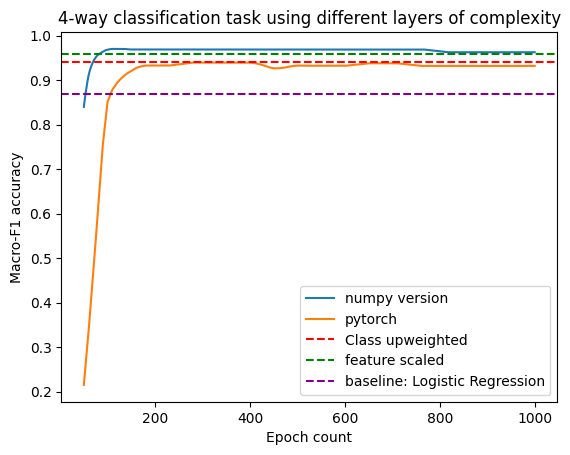

In [21]:
plt.title("4-way classification task using different layers of complexity")
plt.xlabel("Epoch count")
plt.ylabel("Macro-F1 accuracy")

plt.plot(pd.Series(raw_accuracies).rolling(window=50).mean(), label='numpy version')
plt.plot(pd.Series(accuracies).rolling(window=50).mean(), label='pytorch')

plt.axhline(class_upweighted_accuracy, linestyle="--", color="red", label='Class upweighted')
plt.axhline(feature_scaled_accuracy, linestyle="--", color="green", label='feature scaled')
plt.axhline(baseline_accuracy, linestyle="--", color="purple", label='baseline: Logistic Regression')

plt.legend()

plt.show()